## packages

In [51]:
import matplotlib.pyplot as plt

from matplotlib.ticker import MultipleLocator, FormatStrFormatter

import numpy as np

import pandas as pd

import os,sys

import copy

import h3

import folium

import branca.colormap as cmp

from shapely.geometry import Point, Polygon

import math

import geopandas as gp

import random

import time

import datetime

import scipy.stats as stats

import warnings

warnings.filterwarnings("ignore")

from scipy.stats import gamma

from scipy.stats import poisson

## udf

In [52]:
'''Get travel distance'''

def Get_distance(point1,point2):
    
    return Point(point1).distance(Point(point2))*111000*1.2

'''Get travel time'''

def Get_travel_time(dis,speed):
    
    return int(dis/speed)

'''Filter Zones'''

def Get_POLYGON(coords):
    if coords.type=='Polygon':
        return coords
    else:
        Score={i:coords[i].area for i in range(len(coords))}
        idx=max(Score, key=Score.get)
        return coords[idx]
    
'''Randomly Generate nodes'''

def Generate_Point(location,Zone_geometry):
    
    Poly=Zone_geometry[location]
    
    coordinates=list(Poly.exterior.coords)
    
    lngs=[x[0] for x in coordinates]
    
    lats=[x[1] for x in coordinates]
    
    lng_min,lng_max=min(lngs),max(lngs)
    
    lat_min,lat_max=min(lats),max(lats)
    
    lat=random.random()*(lat_max-lat_min)+lat_min
    
    lng=random.random()*(lng_max-lng_min)+lng_min
    
    pnt=Point(lng,lat)
    
    while Poly.contains(pnt)!=True:
        
        lat=random.random()*(lat_max-lat_min)+lat_min
    
        lng=random.random()*(lng_max-lng_min)+lng_min
    
        pnt=Point(lng,lat)
        
    return [lat,lng]

'''Week Transfer'''

def get_week_day(date):
    
    date=datetime.datetime.strptime(date, '%Y-%m-%d')
    
    week_day_dict = {
    0 : 'MON',
    1 : 'TUE',
    2 : 'WED',
    3 : 'THU',
    4 : 'FRI',
    5 : 'SAT',
    6 : 'SUN',
    }
    day = date.weekday()
    
    return week_day_dict[day]

def Get_minute(step):
    
    return int(step/6)

'''Stochastic '''

def Truncated_Gauss(mu,sigma,lower,upper):

    X = stats.truncnorm((lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma)
    
    return round(X.rvs(1)[0],2)

'''Surging Pricing'''

def Trip_Price(distance,duration,base_fare=2.55,minimum_fare=7):
    
    fare=base_fare+distance*1.75+0.35*duration
    
    fare=max(fare,minimum_fare)
    
    return fare

def Food_Price(distance):
    
    if distance<=5:
        
        fare=5
        
    elif distance>5 and distance<=15:
        
        fare=10
        
    else:
        
        fare=15
    
    return fare
        

## param

In [74]:
'''Param'''

resolution = 9

s_sec=25200

e_sec=36000

speed=20000/360

Driver_num=3000

'''Path'''

Demand_path='./data/demand/'

Figure_path = './figures/'

'''Matching patience'''

Mean_match=5

Min_match=3

Max_match=7

Waiting_match=2


'''Load data'''

'''Grid-related data'''

Grid_list=np.load('./Data/NYC_Network/Grids.npy',allow_pickle=True)


'''Point-related data'''

Points_list=np.load('./Data/NYC_Network/Points_list.npy',allow_pickle=True)

Link_Point=np.load('./Data/NYC_Network/Link_Point.npy',allow_pickle=True).item()

Point_coordinate=np.load('./Data/NYC_Network/Point_coordinate.npy',allow_pickle=True).item()

Point_Grid=np.load('./Data/NYC_Network/Point_Grid.npy',allow_pickle=True).item()

''' Dividing NYC to Zones'''

Zone_data = gp.read_file('./Data/NYC_Zones/geo_export_789b911c-2a6d-4092-a682-6c5e6ce53409.shp')

Zone_data=Zone_data[['borough','zone','geometry','location_i']]

Zone_data=Zone_data.loc[Zone_data['borough']=='Manhattan']

Zone_data=Zone_data.reset_index(drop=True)

Zone_data['Zone_id']=['Zone_'+str(i) for i in Zone_data.index]

Zone_data=Zone_data[['Zone_id','borough','zone','geometry','location_i']]

Islands=['Zone_19','Zone_20','Zone_21','Zone_38','Zone_47','Zone_48']

# Islands=['Zone_19','Zone_20','Zone_21']

Zone_data=Zone_data.loc[~Zone_data['Zone_id'].isin(Islands)]

Zone_data=Zone_data.reset_index(drop=True)

Zone_data['Zone_id']=['Zone_'+str(i) for i in Zone_data.index]

Zone_data['geometry']=Zone_data.apply(lambda x:Get_POLYGON(x['geometry']),axis=1)

Zone_data['center'] = Zone_data.apply(lambda x:x['geometry'].centroid,axis=1)

Zone_data=Zone_data.rename(columns={'location_i':'LocationID'})

Zone_data[['LocationID']] = Zone_data[['LocationID']].astype(float)

Zone_data['type']=Zone_data.apply(lambda x:x['geometry'].type,axis=1)


Zone_geometry={}

for idx,row in Zone_data.iterrows():
    
    Zone_geometry[row['LocationID']]=row['geometry']


Locations=Zone_data['LocationID'].tolist()

## date range

In [75]:
'''Pick up 10 week days'''

Weekdays=[]

Dates=[str(x)[:10] for x in pd.date_range('12/1/2020','12/01/2020')]

for dt in Dates:
    
    if get_week_day(dt) not in ['SAT','SUN']:
        
        Weekdays.append(dt)
        
    if len(Weekdays)>10:
        
        break
        
# time stamp

Start_step=2520 # Start stamp 

End_step=3600 # End stamp 


## trip order data collection

In [76]:
GetStamp=lambda x:time.mktime(time.strptime(x,'%Y-%m-%d %H:%M:%S'))

Order_df=pd.read_csv(os.path.join(Demand_path,'yellow_tripdata_2020-12.csv'))

Order_df=Order_df[['tpep_pickup_datetime','PULocationID','DOLocationID']]

Order_df=Order_df.loc[(Order_df['PULocationID'].isin(Locations))&(Order_df['DOLocationID'].isin(Locations))]

Order_df['date']=Order_df.apply(lambda x:x['tpep_pickup_datetime'][0:10],axis=1)

Order_df['Arrive_stamp']=Order_df.apply(lambda x:GetStamp(x['tpep_pickup_datetime']),axis=1)

Order_df['Order_id'] = ['TO'+str(i) for i in Order_df.index]

Order_df['Driver_id'] = 'Waiting'

Order_Num={}

for dt in Dates:
    
    order_df=copy.deepcopy(Order_df.loc[Order_df['date']==dt])
    
    # normalize the arrival time step
    
    base_line=GetStamp(dt+' 00:00:00')
    
    order_df['Arrive_second']=order_df.apply(lambda x:int(x['Arrive_stamp']-base_line),axis=1)
    
    order_df['Arrive_step']=order_df.apply(lambda x:int(x['Arrive_second']/10),axis=1)
    
    order_df=order_df.loc[(order_df['Arrive_step']>=Start_step)&(order_df['Arrive_step']<End_step)]
    
    order_df['Response_step']=float('inf')
    
    order_df['Pickup_step']=float('inf')
    
    # map matching
    
    order_df['Pickup_Point']=order_df.apply(lambda x:Generate_Point(x['PULocationID'],Zone_geometry),axis=1)

    order_df['Dropoff_Point']=order_df.apply(lambda x:Generate_Point(x['DOLocationID'],Zone_geometry),axis=1)

    order_df['Pickup_Latitude']=order_df.apply(lambda x:x['Pickup_Point'][0],axis=1)

    order_df['Pickup_Longitude']=order_df.apply(lambda x:x['Pickup_Point'][1],axis=1)

    order_df['Dropoff_Latitude']=order_df.apply(lambda x:x['Dropoff_Point'][0],axis=1)

    order_df['Dropoff_Longitude']=order_df.apply(lambda x:x['Dropoff_Point'][1],axis=1)

    order_df['Pickup_Grid']=order_df.apply(lambda x:h3.geo_to_h3(x['Pickup_Latitude'],x['Pickup_Longitude'],resolution),axis=1)

    order_df['Dropoff_Grid']=order_df.apply(lambda x:h3.geo_to_h3(x['Dropoff_Latitude'],x['Dropoff_Longitude'],resolution),axis=1)
    
    order_df=order_df.loc[order_df['Pickup_Grid'].isin(Grid_list)]
    
    order_df=order_df.loc[order_df['Dropoff_Grid'].isin(Grid_list)]
    
    # calculate the distance and travel time
     
    order_df['Travel_distance(m)']=order_df.apply(lambda x:Get_distance(x['Pickup_Point'],x['Dropoff_Point']),axis=1)
    
    order_df['Travel_time(10s)']=order_df.apply(lambda x:int(Get_travel_time(x['Travel_distance(m)'],speed)),axis=1)
    
    # matching patience
    
    order_df['Matching_patience(10s)']=order_df.apply(lambda x:Truncated_Gauss(Mean_match,Waiting_match,Min_match,Max_match),axis=1)
    
    # Fare

    order_df['Fare($)']=order_df.apply(lambda x:Trip_Price((x['Travel_distance(m)']/1000.0)*0.62,x['Travel_time(10s)']/6.0),axis=1)
    
    # Collection
    
    order_df=order_df.sort_values(by=['Arrive_step'])
    
    order_df=order_df[['Order_id', 'Driver_id',\
                       'Arrive_step', 'Response_step', 'Pickup_step',\
                       'Pickup_Latitude', 'Pickup_Longitude', 'Dropoff_Latitude','Dropoff_Longitude', 'Pickup_Grid', 'Dropoff_Grid',\
                       'Travel_distance(m)', 'Travel_time(10s)',\
                       'Matching_patience(10s)','Fare($)']]
    
    order_df.to_csv(os.path.join(Demand_path,'Trip_Order_df_'+str(dt)+'.csv'))
    
    print(f'The number of orders in '+str(dt)+' is '+str(order_df.shape[0]))
    

The number of orders in 2020-12-01 is 7227


## food order data

In [98]:
# 01 collect the information of restaurant

Restaurant_df=pd.read_csv(os.path.join(Demand_path,'restaurant.csv'))

Restaurant_df=Restaurant_df.drop(columns=['Unnamed: 0'])

Restaurant_coordinates={}

Restaurant_grid={}

Restaurant_prob={}

for idx,row in Restaurant_df.iterrows():
    
    Restaurant_coordinates[row.restaurant_id]=(row.latitude,row.longitude)
    
    Restaurant_grid[row.restaurant_id]=row.grid
    
    Restaurant_prob[row.restaurant_id]=row.prob

Restaurant_df

# 02 parameters of the distribution of food order

fit_alpha, fit_loc, fit_beta =2.1048234597327085,74.43668658964711,1046.7006141120974

# 02 Possion parameter of arrival

arrival_num=3


# 03 generate orders

for dt in Dates:

    order_num=0

    order_df=pd.DataFrame([],columns=['Order_id', 'Driver_id',\
                       'Arrive_step', 'Response_step', 'Pickup_step',\
                       'Pickup_Latitude', 'Pickup_Longitude', 'Dropoff_Latitude','Dropoff_Longitude', 'Pickup_Grid', 'Dropoff_Grid',\
                       'Travel_distance(m)', 'Travel_time(10s)',\
                       'Matching_patience(10s)','Fare($)'])

    for step in range(Start_step,End_step,1):

        for i in range(poisson.rvs(arrival_num)):

            # select a restaurant

            restaurant_id=np.random.choice(list(Restaurant_prob.keys()),p=list(Restaurant_prob.values()))

            # sample a delivery distance

            delivery_distance=gamma.rvs(fit_alpha, fit_loc, fit_beta)

            degree_distance=delivery_distance/111139.0

            # the location of customer

            r_lng,r_lat=Restaurant_coordinates[restaurant_id][1],Restaurant_coordinates[restaurant_id][0]

            r_grid=Restaurant_grid[restaurant_id]

            angle = np.random.random()*np.pi*2

            c_lng,c_lat = r_lng + np.cos(angle)*degree_distance,r_lat + np.sin(angle)*degree_distance

            c_grid = h3.geo_to_h3(c_lat,c_lng,resolution)

            while c_grid not in Grid_list:

                angle = np.random.random()*np.pi*2

                c_lng,c_lat = r_lng + np.cos(angle)*degree_distance,r_lat + np.sin(angle)*degree_distance

                c_grid = h3.geo_to_h3(c_lat,c_lng,resolution)

            # add an item in the dataframe

            Added_item={}

            order_id='FO'+str(order_num)

            Added_item['Order_id']=order_id
            
            Added_item['Driver_id'] = 'Waiting'

            Added_item['Arrive_step']=step
            
            Added_item['Response_step']=float('inf')
    
            Added_item['Pickup_step']=float('inf')

            Added_item['Pickup_Latitude']=r_lat

            Added_item['Pickup_Longitude']=r_lng

            Added_item['Dropoff_Latitude']=c_lat

            Added_item['Dropoff_Longitude']=c_lng
            
            Added_item['Pickup_Grid']=r_grid

            Added_item['Dropoff_Grid']=c_grid

            Added_item['Pickup_Point']=[r_lat,r_lng]
            
            Added_item['Dropoff_Point']=[c_lat,c_lng]
            
            # calculate the distance and travel time
     
            Added_item['Travel_distance(m)']=Get_distance(Added_item['Pickup_Point'],Added_item['Dropoff_Point'])
    
            Added_item['Travel_time(10s)']=order_df.apply(lambda x:int(Get_travel_time(x['Travel_distance(m)'],speed)),axis=1)
    
            # matching patience
    
            Added_item['Matching_patience(10s)']=Truncated_Gauss(Mean_match,Waiting_match,Min_match,Max_match)
    
            # Fare

            Added_item['Fare($)']=Food_Price(Added_item['Travel_distance(m)']/1000)
            
            # append
    
            order_df=order_df.append(Added_item, ignore_index=True)

            order_num+=1

    # Collection
    
    order_df=order_df.sort_values(by=['Arrive_step'])
    
    order_df=order_df[['Order_id', 'Driver_id',\
                       'Arrive_step', 'Response_step', 'Pickup_step',\
                       'Pickup_Latitude', 'Pickup_Longitude', 'Dropoff_Latitude','Dropoff_Longitude', 'Pickup_Grid', 'Dropoff_Grid',\
                       'Travel_distance(m)', 'Travel_time(10s)',\
                       'Matching_patience(10s)','Fare($)']]
    
    order_df.to_csv(os.path.join(Demand_path,'Food_Order_df_'+str(dt)+'.csv'))
    
    print(f'The number of orders in '+str(dt)+' is '+str(order_df.shape[0]))

The number of orders in 2020-12-01 is 3157


## spatial visualization

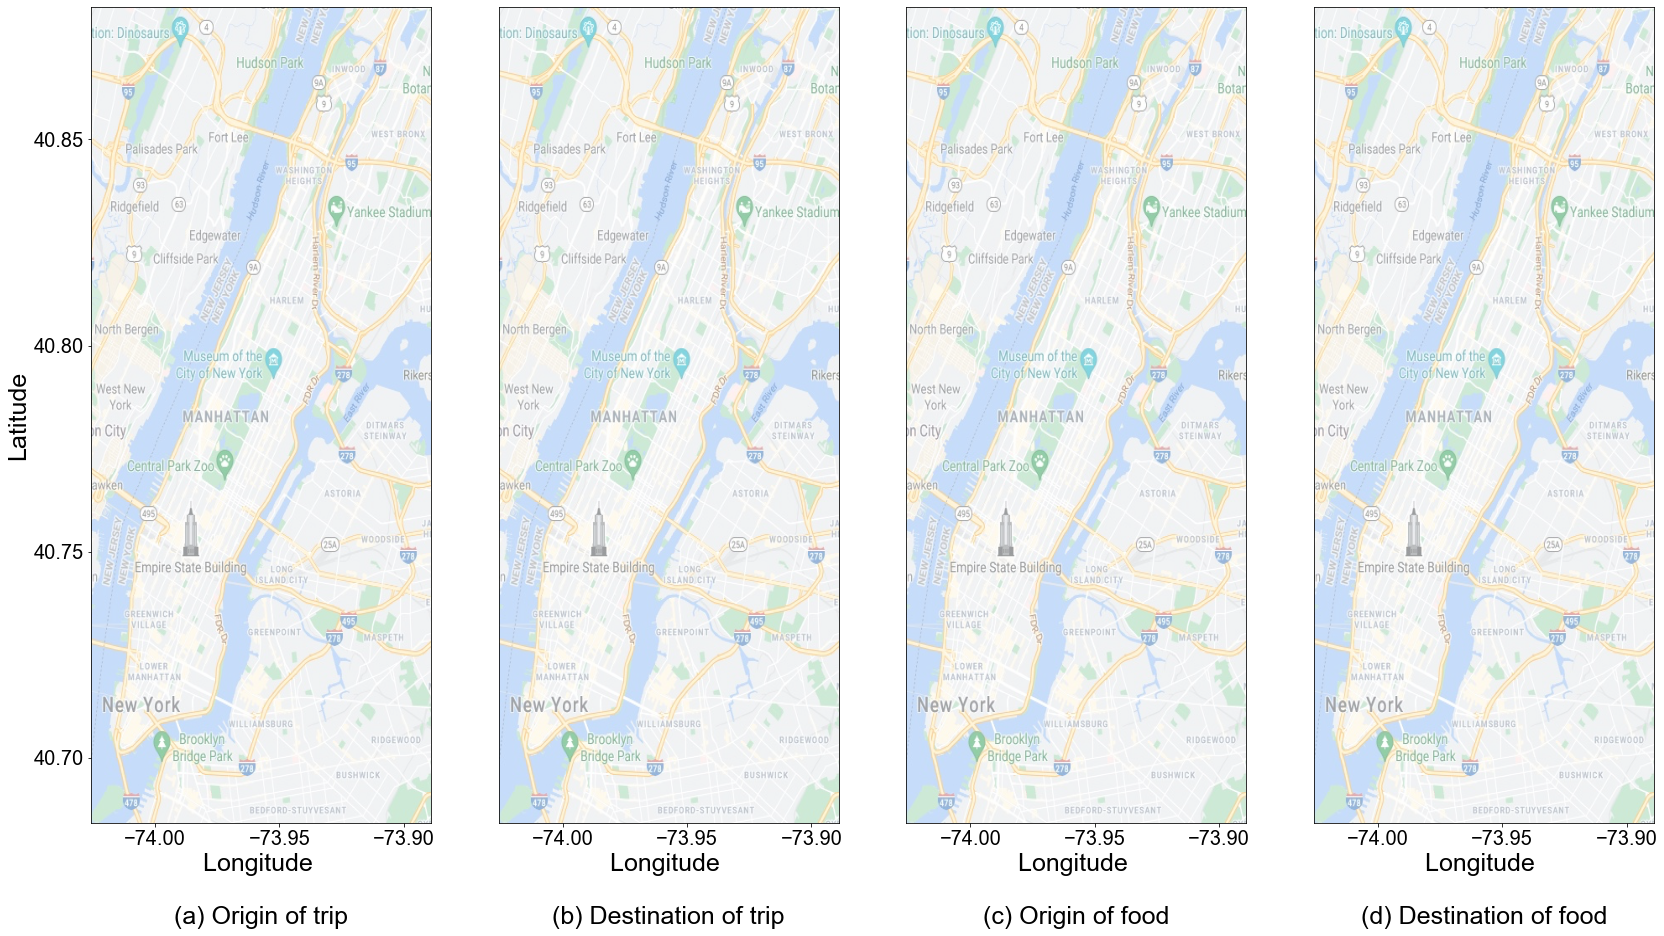

In [99]:
Southwest=[40.684289, -74.025695]

Northeast=[40.882081, -73.889064]

Map_path='./data/map/'

font_title = {'family' : 'Arial','weight' : 'normal','size': 25}

font_label = {'family' : 'Arial','weight' : 'normal','size': 25}

font_legend = {'family' : 'Arial','weight' : 'normal','size': 20}

Titles=['(a) Origin of trip','(b) Destination of trip','(c) Origin of food','(d) Destination of food',]

# Titles=['(a) ','(b) ','(c) ','(d) ']


def Background(area,sw,ne):
    
    bg_path=Map_path+area+'.png'
    
    img = plt.imread(bg_path)
    
    figsize = 28,15
    
    figure, ax1 = plt.subplots(1,4,figsize=figsize)
    
    xgrange, ygrange = ((sw[1], ne[1]), (sw[0], ne[0]))
    
    for i in range(4):

            labels = ax1[i].get_xticklabels() + ax1[i].get_yticklabels()

            [label.set_fontsize(20) for label in labels]

            [label.set_fontname('Arial') for label in labels]

            ax1[i].set_xlim(xgrange)

            ax1[i].set_ylim(ygrange)

            x0,x1 = ax1[i].get_xlim()

            y0,y1 = ax1[i].get_ylim()

            ax1[i].imshow(img, extent=[x0, x1, y0, y1], aspect='auto', alpha=.5)

            ax1[i].set_xlabel('Longitude \n\n'+Titles[i],font_label)

            xmajorLocator   = MultipleLocator(0.05)

            ax1[i].xaxis.set_major_locator(xmajorLocator)

            if i!=0:

                ax1[i].set_yticks([])

            else:

                ax1[i].set_ylabel('Latitude',font_label)

                ymajorLocator1   = MultipleLocator(0.05)

                ax1[i].yaxis.set_major_locator(ymajorLocator1)
    
    return figure, ax1

figure, ax1=Background('NYC',Southwest,Northeast)




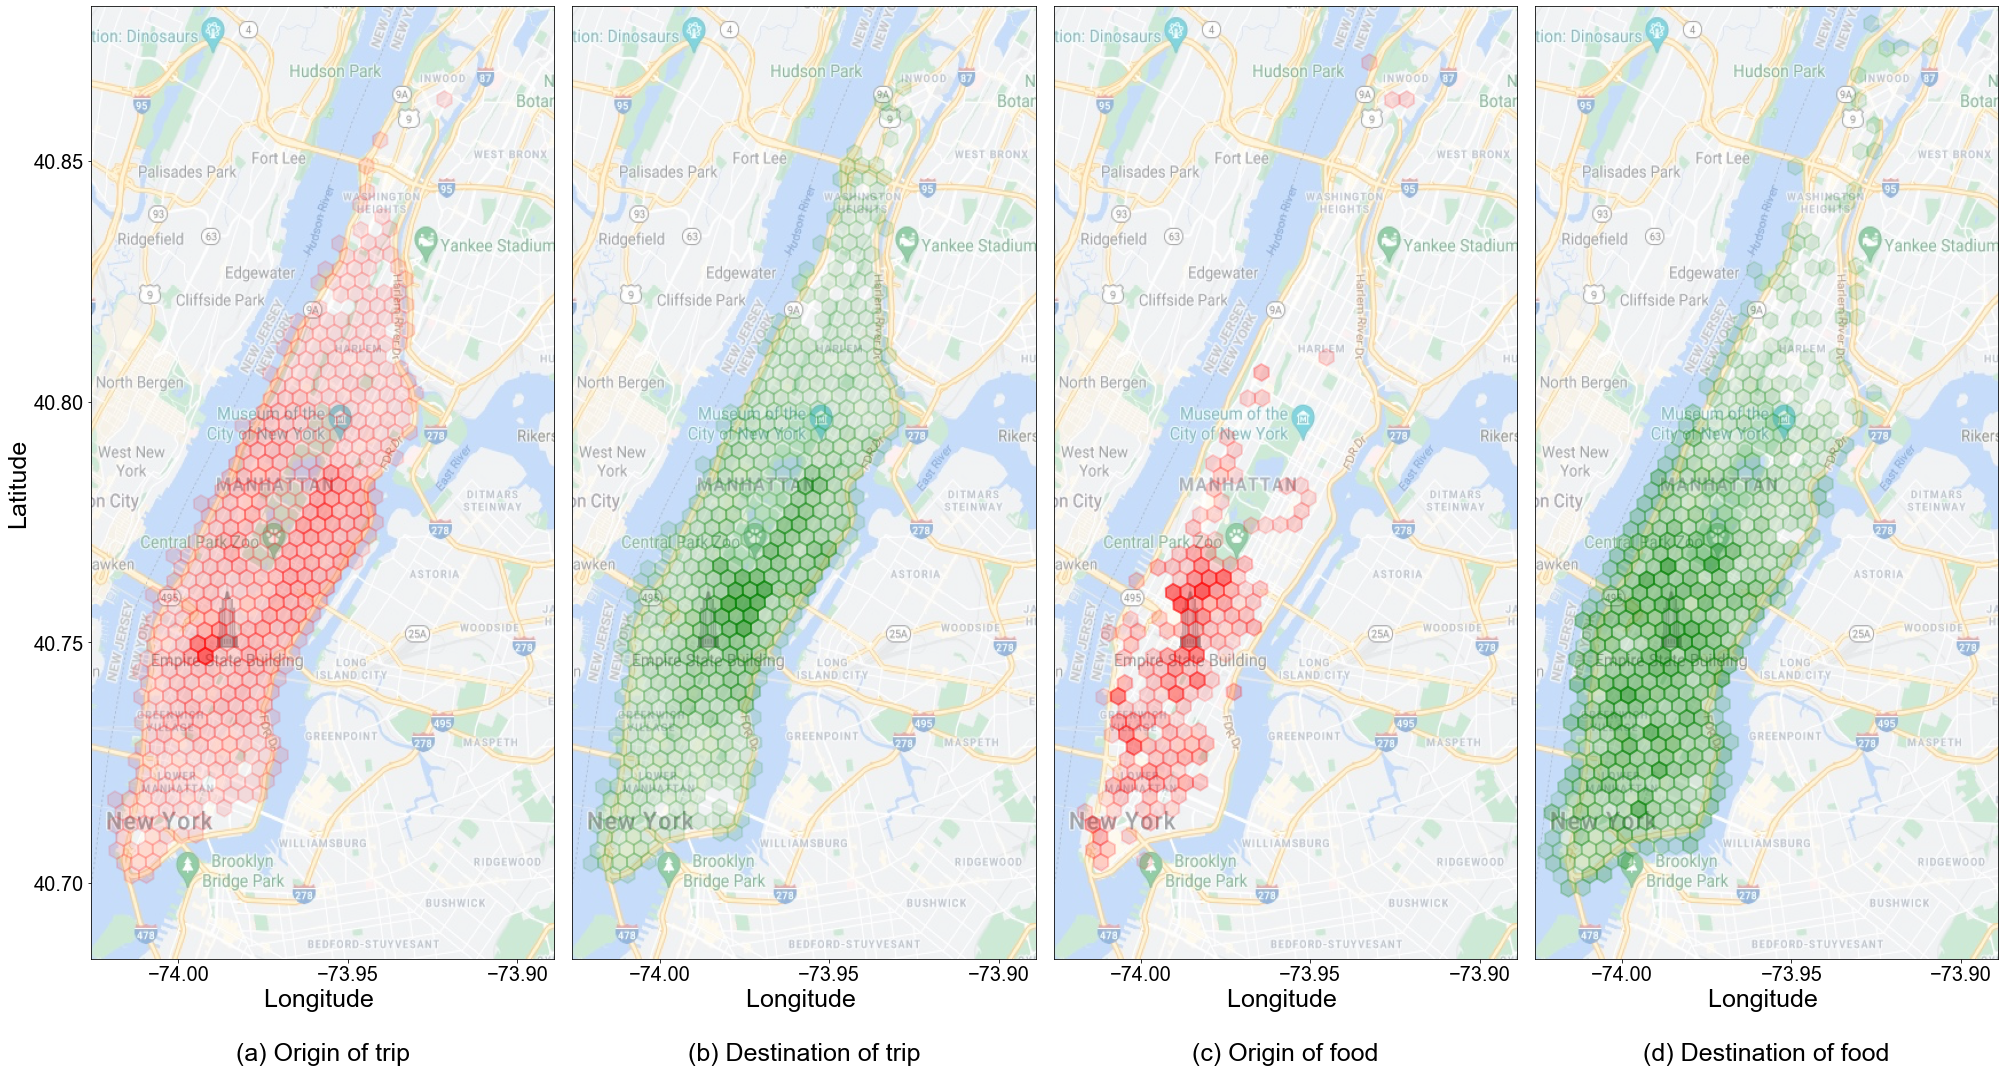

In [100]:
def spatila_ratio(df,grid):
    
    stat_df=df.groupby([grid]).count()

    stat_df['grid']=stat_df.index
    
    stat_df['ratio']=(stat_df.Order_id-stat_df.Order_id.min())/(stat_df.Order_id.max()-stat_df.Order_id.min())
    
    return stat_df[['grid','ratio']]

# plot figure

figure, axs=Background('NYC',Southwest,Northeast)


order_df=pd.read_csv(os.path.join(Demand_path,'Trip_Order_df_'+str(dt)+'.csv'))

for idx,row in spatila_ratio(order_df,'Pickup_Grid').iterrows():

    grid=row['grid']

    ratio=(row['ratio']/2)+0.1

    boundary=[[float(x[1]),float(x[0])] for x in h3.h3_to_geo_boundary(grid)]

    pgon = plt.Polygon(boundary,color='r',linewidth=2,fill=True,alpha=ratio)

    axs[0].add_patch(pgon)
    
for idx,row in spatila_ratio(order_df,'Dropoff_Grid').iterrows():

    grid=row['grid']

    ratio=(row['ratio']/2)+0.1

    boundary=[[float(x[1]),float(x[0])] for x in h3.h3_to_geo_boundary(grid)]

    pgon = plt.Polygon(boundary,color='g',linewidth=2,fill=True,alpha=ratio)

    axs[1].add_patch(pgon)
    
    
order_df=pd.read_csv(os.path.join(Demand_path,'Food_Order_df_'+str(dt)+'.csv'))

for idx,row in spatila_ratio(order_df,'Pickup_Grid').iterrows():

    grid=row['grid']

    ratio=(row['ratio']/2)+0.1

    boundary=[[float(x[1]),float(x[0])] for x in h3.h3_to_geo_boundary(grid)]

    pgon = plt.Polygon(boundary,color='r',linewidth=2,fill=True,alpha=ratio)

    axs[2].add_patch(pgon)
    
for idx,row in spatila_ratio(order_df,'Dropoff_Grid').iterrows():

    grid=row['grid']

    ratio=(row['ratio']/2)+0.1

    boundary=[[float(x[1]),float(x[0])] for x in h3.h3_to_geo_boundary(grid)]

    pgon = plt.Polygon(boundary,color='g',linewidth=2,fill=True,alpha=ratio)

    axs[3].add_patch(pgon)


plt.tight_layout()

current_fig = plt.gcf() # 'get current figure'

current_fig.savefig(os.path.join(Figure_path,'Heatmap_OD.png'), format='png', bbox_inches = 'tight')

plt.show()

    




## minute distribution

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


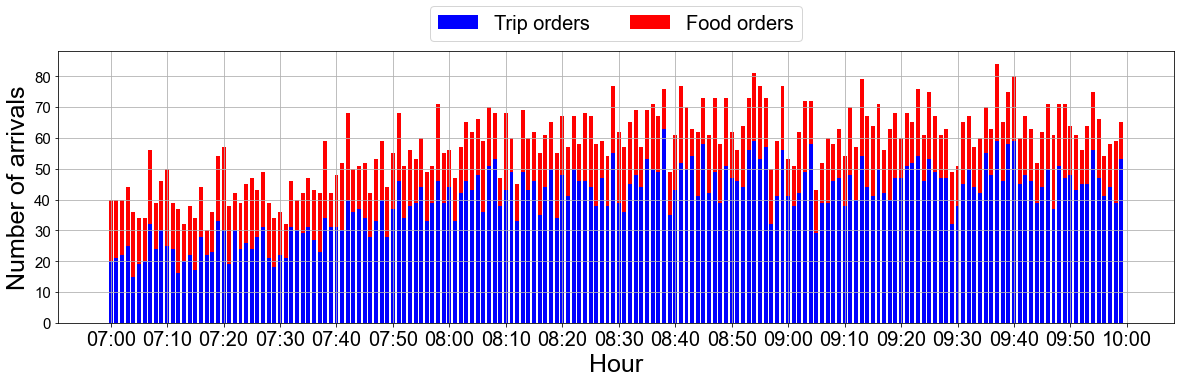

In [104]:
def minute_stat(df):
    
    df['minute']=df.apply(lambda x:int((x['Arrive_step']-Start_step)/6.0),axis=1)
    
    stat_df=df.groupby(['minute']).count()

    stat_df['minute']=stat_df.index
    
    stat_df=stat_df.reset_index(drop=True)
    
    return stat_df[['minute','Order_id']]




'''Plot Figure'''

figsize = 20,5

font_title = {'family' : 'Arial','weight' : 'normal','size': 40}

font_label = {'family' : 'Arial','weight' : 'normal','size': 25}

font_legend = {'family' : 'Arial','weight' : 'normal','size': 20}

figure, ax1 = plt.subplots(figsize=figsize)

labels = ax1.get_xticklabels() + ax1.get_yticklabels()

[label.set_fontsize(15) for label in labels]

[label.set_fontname('Arial') for label in labels]

'''Plot'''

order_df=pd.read_csv(os.path.join(Demand_path,'Trip_Order_df_'+str(dt)+'.csv'))

stat_df=minute_stat(order_df)

cumulative=[0  for i in stat_df.minute.to_list()]

ax1.bar(stat_df['minute'],\
        stat_df['Order_id'],\
        bottom=cumulative,
        width = 0.7,\
        facecolor = 'blue',\
        label='Trip orders')

cumulative=[stat_df.Order_id.to_list()[i]+cumulative[i] for i in stat_df.minute.to_list()]

order_df=pd.read_csv(os.path.join(Demand_path,'Food_Order_df_'+str(dt)+'.csv'))

stat_df=minute_stat(order_df)


ax1.bar(stat_df['minute'],\
        stat_df['Order_id'],\
        bottom=cumulative,
        width = 0.7,\
        facecolor = 'red',\
        label='Food orders')



ax1.set_ylabel('Number of arrivals',font_label)

ax1.set_xlabel('Hour',font_label)


xmajorLocator   = MultipleLocator(10)

ax1.xaxis.set_major_locator(xmajorLocator) 


# ax1.set_ylim([0,175])

ax1.set_xticklabels(['','07:00', '07:10','07:20','07:30','07:40','07:50',\
                        '08:00', '08:10','08:20','08:30','08:40','08:50',\
                        '09:00', '09:10','09:20','09:30','09:40','09:50','10:00'],font_legend)

ax1.legend(loc='center', bbox_to_anchor=(0.5, 1.1), prop=font_legend,ncol=2)

plt.grid()

current_fig = plt.gcf() # 'get current figure'

current_fig.savefig(os.path.join(Figure_path,'Demand_Arrivals.eps'), format='eps', dpi=1000, bbox_inches = 'tight')

plt.show()
